In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM, Bidirectional

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

2024-11-14 18:06:23.242610: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 18:06:23.266115: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 18:06:23.795322: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# file_path = tf.keras.utils.get_file("kor.txt",
#              "https://raw.githubusercontent.com/ironmanciti/infran_NLP/main/data/kor.txt")

In [3]:
file_path = "../data/kor.txt"

with open(file_path, 'r', encoding='utf-8') as f:
    data = f.readlines()

eng_texts = []
kor_inputs = []
kor_targets = []
for text in data:
    
    if '\t' not in text:
        continue

    english, korean, attribution = text.split('\t')
    input = '<sos> ' + korean # teacher forcing 용도
    target = korean + ' <eos>'

    eng_texts.append(english)
    kor_inputs.append(input)
    kor_targets.append(target)

print(len(eng_texts), len(kor_inputs), len(kor_targets),"\n")
print("English :", eng_texts[1100:1110])
print("\nTeacher Forcing Input :", kor_inputs[1100:1110])
print("\nTeacher Forcing Target", kor_targets[1100:1110])

5890 5890 5890 

English : ['Can rabbits swim?', 'Can we talk here?', 'Choose carefully.', 'Come immediately.', 'Did you know him?', 'Do you like fish?', 'Do you like fish?', 'Do you like fish?', 'Do you like fish?', 'Do you like tofu?']

Teacher Forcing Input : ['<sos> 토끼는 수영할 수 있을까?', '<sos> 여기서 대화해도 될까요?', '<sos> 신중하게 골라.', '<sos> 즉시 와.', '<sos> 그를 알고 계셨어요?', '<sos> 생선 좋아해요?', '<sos> 생선 좋아해?', '<sos> 물고기 좋아하나요?', '<sos> 물고기 좋아해?', '<sos> 두부 좋아해?']

Teacher Forcing Target ['토끼는 수영할 수 있을까? <eos>', '여기서 대화해도 될까요? <eos>', '신중하게 골라. <eos>', '즉시 와. <eos>', '그를 알고 계셨어요? <eos>', '생선 좋아해요? <eos>', '생선 좋아해? <eos>', '물고기 좋아하나요? <eos>', '물고기 좋아해? <eos>', '두부 좋아해? <eos>']


In [4]:
vocab = 10000
tokenizer_eng = Tokenizer(num_words=vocab)
tokenizer_eng.fit_on_texts(eng_texts)
eng_sequences = tokenizer_eng.texts_to_sequences(eng_texts)
print('ENG')
print(eng_sequences[1500])
print(eng_texts[1500])
print("-"*30)
tokenizer_kor = Tokenizer(num_words=vocab, filters = "") # <eos>, <bos>가 filtering되지 않기 위해서 이렇게 처리
tokenizer_kor.fit_on_texts(kor_inputs + kor_targets)
kor_input_sequences = tokenizer_kor.texts_to_sequences(kor_inputs)
kor_target_sequences = tokenizer_kor.texts_to_sequences(kor_targets)
print('KOR')
print(kor_input_sequences[1500])
print(kor_inputs[1500])
print(kor_target_sequences[1500])
print(kor_targets[1500])
print("-"*30)

ENG
[1, 1397, 2, 7, 774]
I baked Tom a cake.
------------------------------
KOR
[1, 4, 106, 1155, 3548]
<sos> 나는 톰에게 케이크를 구워줬다.
[4, 106, 1155, 3548, 2]
나는 톰에게 케이크를 구워줬다. <eos>
------------------------------


In [5]:
word2idx_eng = tokenizer_eng.word_index
max_len_eng = max([len(text.split(' ')) for text in eng_texts] )
num_words_eng = min(vocab, len(tokenizer_eng.word_index) + 1)
print(max_len_eng, num_words_eng)

word2idx_kor = tokenizer_kor.word_index
max_len_kor = max([len(text.split(' ')) for text in kor_inputs])
num_words_kor = len(tokenizer_kor.word_index) + 1
print(max_len_kor, num_words_kor)

101 3200
90 8288


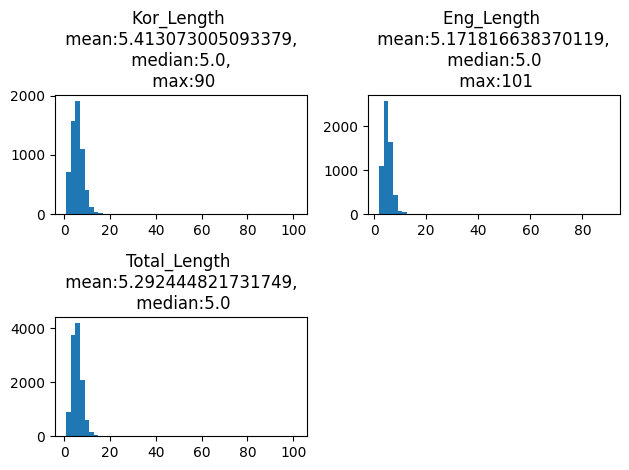

In [6]:
import matplotlib.pyplot as plt
kor_length_lst = [len(text.split(' ')) for text in eng_texts] 
eng_length_lst = [len(text.split(' ')) for text in kor_inputs] 
plt.subplot(2,2,1)
plt.hist(kor_length_lst, bins=50)
mean = np.mean(kor_length_lst)
median = np.median(kor_length_lst)
max_len_kor = max([len(text.split(' ')) for text in kor_inputs])
plt.title(f"Kor_Length \n mean:{mean}, \n median:{median}, \n max:{max_len_kor}")
plt.subplot(2,2,2)
plt.hist(eng_length_lst, bins=50)
mean = np.mean(eng_length_lst)
median = np.median(eng_length_lst)
max_len_eng = max([len(text.split(' ')) for text in eng_texts] )
plt.title(f"Eng_Length \n mean:{mean}, \n median:{median} \n max:{max_len_eng}")
plt.subplot(2,2,3)
plt.hist(kor_length_lst+eng_length_lst, bins=50)
mean = np.mean(kor_length_lst+eng_length_lst)
median = np.median(kor_length_lst+eng_length_lst)
plt.title(f"Total_Length \n mean:{mean}, \n median:{median}")
plt.tight_layout()

encoder는 thought vector 생성 목적이므로 pre로 padding

decoder는 teacher forcing을 해야하므로 post로 padding

In [7]:
# 영어 시퀀스를 패딩 처리하여 인코더 입력으로 변환 (최대 길이 max_len_eng로 설정)
encoder_inputs = pad_sequences(eng_sequences, maxlen=max_len_eng, padding='pre')
print("encoder input shape :", encoder_inputs.shape)
print("encoder_inputs[0] : \n", encoder_inputs[1500])

# 한국어 입력 시퀀스를 패딩 처리하여 디코더 입력으로 변환 (최대 길이 max_len_kor로 설정, 'post' 방식으로 패딩)
decoder_inputs = pad_sequences(kor_input_sequences, maxlen=max_len_kor, padding="post")
print("\ndecoder input shape :", decoder_inputs.shape)
print("decoder_inputs[0] : \n", decoder_inputs[1500])

# 한국어 타겟 시퀀스를 패딩 처리하여 디코더 타겟으로 변환 (최대 길이 max_len_kor로 설정, 'post' 방식으로 패딩)
decoder_targets = pad_sequences(kor_target_sequences, maxlen=max_len_kor, padding="post")
print("\ndecoder target shape :", decoder_targets.shape)
print("decoder_targets[0] : \n", decoder_targets[1500])

encoder input shape : (5890, 101)
encoder_inputs[0] : 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    1 1397
    2    7  774]

decoder input shape : (5890, 90)
decoder_inputs[0] : 
 [   1    4  106 1155 3548    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    

In [8]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("danielwillgeorge/glove6b100dtxt")
print("Path to dataset files:", path)
path = os.path.join(path, 'glove.6B.100d.txt')
with open(path, 'r',encoding='utf-8') as f:
    eng_glove_embedding = f.readlines()

/home/paradeigma/workspace/python/nlp_module/nlp_module_3_9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/paradeigma/.cache/kagglehub/datasets/danielwillgeorge/glove6b100dtxt/versions/1


In [9]:
import re
embedding_dim = 100
embeddings_dict = dict()
for data in eng_glove_embedding:
    data = re.sub("\n","", data)
    word = data.split(' ')[0]
    embeddings = np.array(data.split(' ')[1:], dtype='float32')
    embeddings_dict[word] = embeddings

embedding_matrix = np.zeros((num_words_eng, embedding_dim))
    
for word, i in tokenizer_eng.word_index.items():
    if i < num_words_eng:
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(num_words_eng, embedding_dim, weights=[embedding_matrix], trainable=True)

In [10]:
latent_dim = 512
encoder_inputs_ = Input(shape=(max_len_eng, ), name='Encoder_Input')
x = embedding_layer(encoder_inputs_)
encoder_outputs, h, c = LSTM(latent_dim, return_sequences=False, return_state=True)(x)
encoder_states = [h, c]
encoder_model = Model(encoder_inputs_, encoder_states)
encoder_model.summary()

Model: "model"


2024-11-14 18:06:47.043958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 18:06:47.074824: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 18:06:47.074868: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 18:06:47.082208: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:c4:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 18:06:47.082247: I tensorflow/compile

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_Input (InputLayer)  [(None, 101)]             0         
                                                                 
 embedding (Embedding)       (None, 101, 100)          320000    
                                                                 
 lstm (LSTM)                 [(None, 512),             1255424   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
Total params: 1575424 (6.01 MB)
Trainable params: 1575424 (6.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
num_words_kor_ = min(vocab, num_words_kor + 1)
decoder_inputs_ = Input(shape=(max_len_kor,), name="Decoder_Input")

# 디코더의 단어 임베딩은 사전 학습된 벡터를 사용하지 않음
decoder_embedding = Embedding(num_words_kor, embedding_dim)
decoder_inputs_x = decoder_embedding(decoder_inputs_)

# 교사 강요(Teacher-forcing)를 위한 디코더 LSTM 정의
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
# 초기 상태를 인코더의 [h, c] 상태로 설정
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# 최종 Dense 레이어 정의
decoder_dense = Dense(num_words_kor, activation='softmax', name='Decoder_Output')
decoder_outputs = decoder_dense(decoder_outputs)

# Teacher-forcing 모델 생성
model_teacher_forcing = Model([encoder_inputs_, decoder_inputs_], decoder_outputs)

# 모델 컴파일 및 훈련 설정
model_teacher_forcing.compile(loss='sparse_categorical_crossentropy',
                              optimizer=Adam(0.001), metrics=['accuracy'])

# 모델 요약 출력
model_teacher_forcing.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Encoder_Input (InputLayer)  [(None, 101)]                0         []                            
                                                                                                  
 Decoder_Input (InputLayer)  [(None, 90)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 101, 100)             320000    ['Encoder_Input[0][0]']       
                                                                                                  
 embedding_1 (Embedding)     (None, 90, 100)              828800    ['Decoder_Input[0][0]']       
                                                                                            

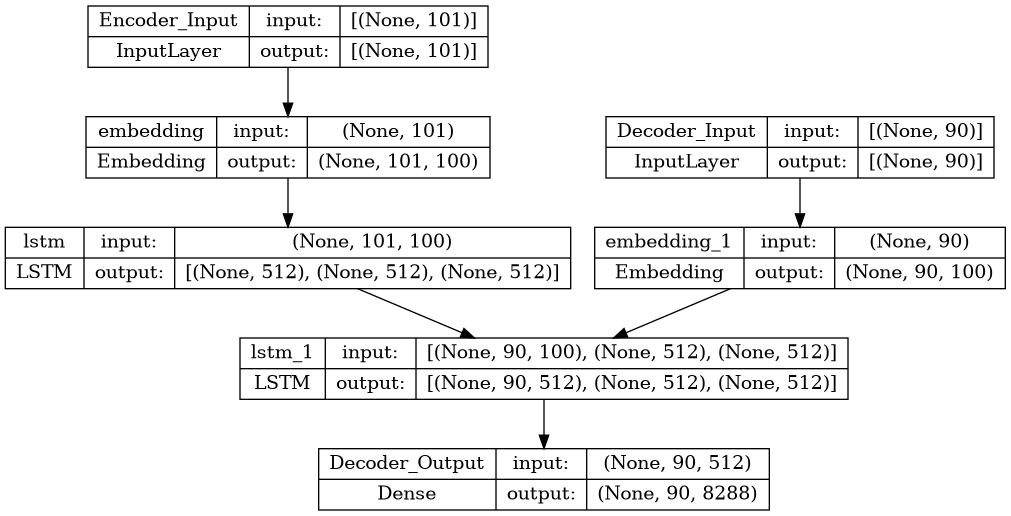

In [12]:
plot_model(model_teacher_forcing, show_shapes=True)

In [20]:
batch_size = 128
epochs = 2
history = model_teacher_forcing.fit([encoder_inputs, decoder_inputs],
                                    decoder_targets, batch_size=batch_size,
                                    epochs=epochs, validation_split=0.2)

Epoch 1/2
37/37 [==============================] - 5s 136ms/step - loss: 0.3469 - accuracy: 0.9534 - val_loss: 0.6843 - val_accuracy: 0.9217
Epoch 2/2
37/37 [==============================] - 6s 167ms/step - loss: 0.3365 - accuracy: 0.9539 - val_loss: 0.6720 - val_accuracy: 0.9221


In [21]:
model_teacher_forcing.save('_10.language_translation.h5')  # 원하는 저장 경로와 파일명을 지정하세요.

/home/paradeigma/workspace/python/nlp_module/nlp_module_3_9/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
decoder_state_input_h = Input(shape=(512,), name='Decoder_hidden_h')
decoder_state_input_c = Input(shape=(512,), name='Decoder_hidden_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_inputs_single = Input(shape=(1,), name='Decoder_input')
x = decoder_embedding(decoder_inputs_single)
decoder_outputs, h, c = decoder_lstm(x, initial_state=decoder_states_inputs)
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

decoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Decoder_input (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     multiple                     828800    ['Decoder_input[0][0]']       
                                                                                                  
 Decoder_hidden_h (InputLay  [(None, 512)]                0         []                            
 er)                                                                                              
                                                                                                  
 Decoder_hidden_c (InputLay  [(None, 512)]                0         []                      

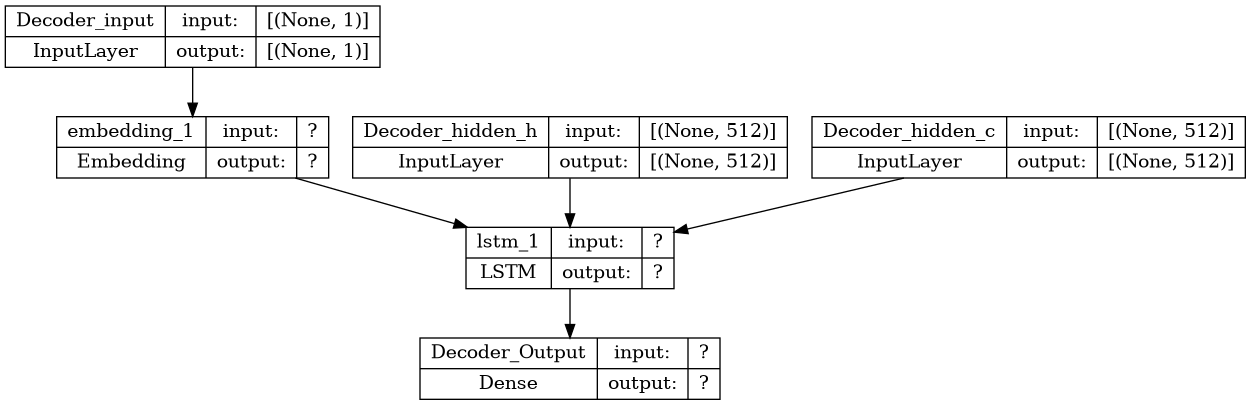

In [23]:
plot_model(decoder_model, show_shapes=True)

In [24]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq, verbose=0)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = word2idx_kor['<sos>']
    eos = word2idx_kor['<eos>']
    output_sentence = []
    for _ in range(max_len_kor):
        output_tokens, h, c = decoder_model.predict([target_seq]+states_value, verbose=0)
        idx = np.argmax(output_tokens[0,0,:]) # argmax로 탐욕적 선택
        if eos == idx:
            break

        if idx > 0 :
            word = tokenizer_kor.index_word[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    result = ' '.join(output_sentence)
    return result

for _ in range(5):
    i = np.random.choice(len(eng_texts))
    input_seq = encoder_inputs[i: i+1]

    translation = decode_sequence(input_seq)
    print('-')
    print('Input:', eng_texts[i])
    print('Translation:', translation)

-
Input: Let's change the subject.
Translation: 톰은
-
Input: Is there anything that you want to tell me?
Translation: 톰은 톰은
-
Input: Give me five days.
Translation: 톰은
-
Input: Why don't you say something?
Translation: 톰은
-
Input: I don't read as many books as I used to.
Translation: 톰은 톰은


In [25]:
def Eng_Kor_translation(txt):
    # 입력된 영어 텍스트를 시퀀스로 변환
    input_sequence = tokenizer_eng.texts_to_sequences([txt])

    # 시퀀스를 패딩 처리하여 인코더 입력으로 변환 (최대 길이를 max_len_eng로 설정)
    encoder_input = pad_sequences(input_sequence, maxlen=max_len_eng)

    # 인코더 입력을 디코더 시퀀스로 변환하여 번역 결과 반환
    return decode_sequence(encoder_input)

In [26]:
test_text = [
       "Your lips are red.",
       "French is interesting.",
       "I like you.",
       "Let's go to home."
]
for text in test_text:
    translation = Eng_Kor_translation(text)
    print('----')
    print('Input:', text)
    print('Translation:', translation)

----
Input: Your lips are red.
Translation: 톰은
----
Input: French is interesting.
Translation: 톰은
----
Input: I like you.
Translation: 톰은
----
Input: Let's go to home.
Translation: 톰은
